In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame
import choroplethNYC as cp
from descartes import PolygonPatch
from censusAPI import myAPI
import requests
import json
import numpy as np
import pandas as pd
import io
import os
import shapely
from geopandas.tools import sjoin
from fiona.crs import from_epsg
import pysal as ps
import matplotlib.pylab as plt
%matplotlib inline
import rtree

/nfshome/tc1767/.conda/envs/myEnv/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


# 1. PUMA : Public Use Microdata Area

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [2]:
if os.getenv("PUIDATA") is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

In [3]:
pumashp = GeoDataFrame.from_file(os.getenv("PUIDATA") + "/geo_export_2348835b-a00f-4c76-9946-5994fc510ed3.shp")
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [4]:
pumashp.crs

{'init': u'epsg:4326'}

## 1.2  plot the PUMA NYC regions

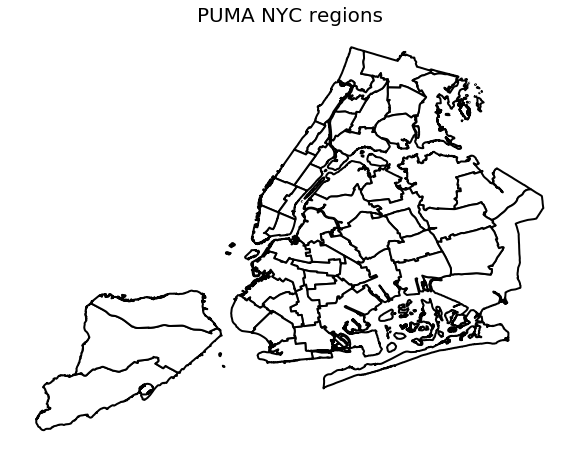

In [11]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("PUMA NYC regions", fontsize = 20)
cp.choroplethNYC(pumashp, ax = ax, column=None, color="white", edgecolor="black", lw=2);


## Figure1: The is a NYC region map divided by Public Use Microdata Area.

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API: 

In [12]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [13]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))
affkeys

array([u'B07007_027E', u'B24010E_007E', u'B08505I_003E', ...,
       u'B19001A_014E', u'B17010_038E', u'B24122_437E'], 
      dtype='<U14')

In [14]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[(u'B28002_008E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 (u'B28002_004E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 (u'B28002_007E',
  u'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL')]

In [15]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{u'attributes': u'B28002_001M,B28002_001EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total',
 u'limit': 0,
 u'predicateType': u'int'}

In [16]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{u'attributes': u'B28002_004M,B28002_004EA',
 u'concept': u'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 u'group': u'B28002',
 u'label': u'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 u'limit': 0,
 u'predicateType': u'int'}

In [17]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [18]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [19]:
pumaBB = pumaBB.drop([u'Unnamed: 4'],axis = 1)
pumaBB['B28002_001E'] = pumaPP['B28002_001E']
pumaBB['pcBB'] = (pumaBB['B28002_004E']/pumaBB['B28002_001E'])*100

In [20]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [21]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.rename(columns = {'GCT_STUB.target-geo-id2' : 'gid'}, inplace = True)
bbpc = bbpc.drop([0])
bbpc['newid'] = bbpc.gid.str[:2]
bbpc.head()

,gid,HC01,HC02,newid
1,01,74.7,0.5,01
2,0100100,70.9,2.5,01
3,0100200,80.5,2.7,01
4,0100301,87.0,2.8,01
5,0100302,81.9,2.9,01


In [22]:
bbpc = bbpc[bbpc.newid.str.contains('36')]
bbpc = bbpc.drop([1412])

In [23]:
bbpc['gid'] = bbpc.gid.str[-4:].astype(int)
bbpc.head()

,gid,HC01,HC02,newid
1413,100,80.6,2.6,36
1414,200,75.7,2.2,36
1415,300,79.8,2.6,36
1416,401,81.4,2.4,36
1417,402,78.2,2.3,36


## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [24]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]
diff_['HC01'] = diff_['HC01'].astype(float)
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"])

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


In [25]:
diff_.head()

,pcBB,HC01,diff
0,80.552879,80.6,0.047121
1,75.733321,75.7,0.033321
2,79.842678,79.8,0.042678
3,81.433409,81.4,0.033409
4,78.150656,78.2,0.049344


# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [26]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [27]:
#choropleth of the percentage of internet axcess
pumashp = pumashp.merge(bbpc,left_on="puma", right_on="gid")

In [28]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,gid,HC01,HC02,newid
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.3,2.6,36
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3702,68.3,3.7,36
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.8,3.2,36
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.6,3.6,36
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,78.8,2.9,36


In [29]:
pumashp['HC01'] = pumashp['HC01'].astype(float)

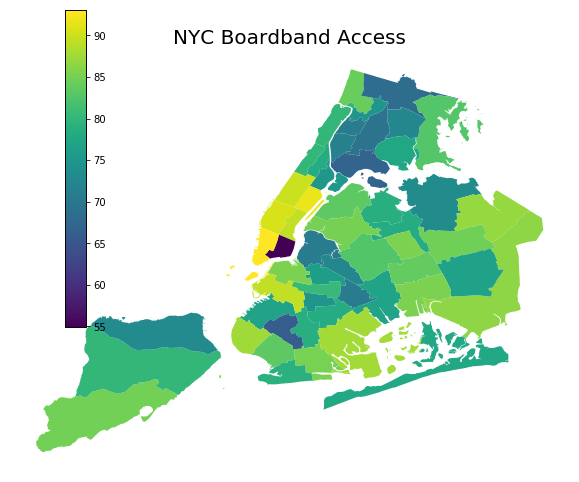

In [39]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("NYC Boardband Access", fontsize = 20)
cp.choroplethNYC(pumashp, ax=ax, column='HC01', kind='continuous', cmap="viridis");

## Figure2: The is a NYC region map divided by Public Use Microdata Area with the percentage of households with broadband access using viridis color map.

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [31]:
linkNYC = pd.read_csv(os.getenv("PUIDATA") + "/linkNYClocations.csv")
linkNYC = linkNYC.drop(['Unnamed: 0',],axis = 1)

In [32]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [33]:
linkNYC.shape

(1414, 4)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab

In [34]:
linkNYC['lonlat'] = list(zip(linkNYC.longitude,linkNYC.latitude))
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [35]:
linkNYC = GeoDataFrame(linkNYC)

In [36]:
linkNYC.crs = from_epsg(4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

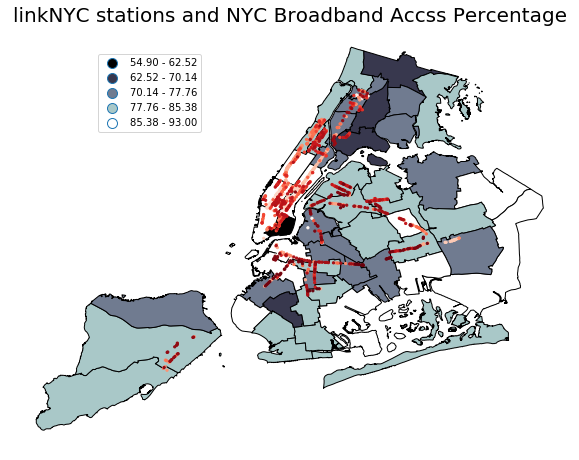

In [41]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("linkNYC stations and NYC Broadband Accss Percentage", fontsize=20)
cp.choroplethNYC(pumashp, column='HC01', kind='continuous', cmap="bone", ax=ax, edgecolor="black", scheme= "Equal_interval", k=5);
linkNYC.plot(ax=ax, marker='o', cmap="Reds", markersize=5)

## Figure3: This is a plot of the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals.

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [45]:
keyPop = 'B00001_001E'

In [46]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [47]:
pumashp = pumashp.merge(pumaPop, right_on="public use microdata area", left_on="puma")
pumashp.head()

,puma,shape_area,shape_leng,geometry,gid,HC01,HC02,newid,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.3,2.6,36,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3702,68.3,3.7,36,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.8,3.2,36,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.6,3.6,36,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,78.8,2.9,36,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


## 5.2 find the number of station per 100 people per PUMA

In [48]:
pumashp_ft = pumashp.to_crs(epsg=2263)
linkNYC_ft = linkNYC.to_crs(epsg=2263)

In [49]:
pumashp_ft.head()

,puma,shape_area,shape_leng,geometry,gid,HC01,HC02,newid,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3701,84.3,2.6,36,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",3702,68.3,3.7,36,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,3703,82.8,3.2,36,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3704,72.6,3.6,36,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",4015,78.8,2.9,36,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


In [75]:
linkpp = gpd.sjoin(pumashp_ft, linkNYC_ft)
linkpp = linkpp.fillna(0)
linkpp = linkpp.groupby("puma")
linkpp = linkpp[['link_site']].count()
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


In [76]:
pumashplc=pumashp.merge(linkpp, right_on='puma', left_on='puma')
pumashplc.head()
pumashplc['linkNYCp100p'] = (100*pumashplc['link_site']/pumashplc['B00001_001E'])
pumashplc['linkNYCp100p'].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals

In [77]:
pumashp['linkNYCp100p']=pumashplc['linkNYCp100p']
pumashp = pumashp.fillna(0)

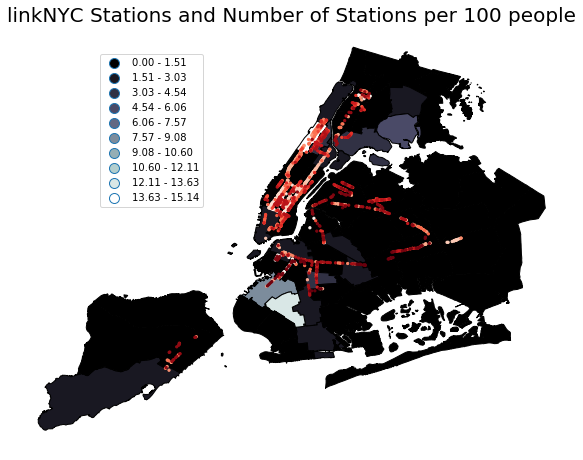

In [80]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("linkNYC Stations and Number of Stations per 100 people", fontsize = 20)
cp.choroplethNYC(pumashp, column='linkNYCp100p', kind='continuous', edgecolor="black", cmap="bone", ax=ax, scheme= "Equal_interval", k=10);
linkNYC.plot(ax=ax, marker='o', cmap="Reds", markersize=5)

## Figure4: This is a plot of plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals.